In [1]:
#Technical Analysis Systems (Apostolos Dasilas)
#Taouktsis Xenofon (dai19312)
#Υπολογισμοί MACD
#Δεδομένα από το [investing.com]
#Τα δεδομένα (.csv) όπως τα κατεβάζουμε απευθείας από το investing.com
#Το αρχείο θα έχει όνομα συμβόλου και μετατροπή από π.χ. ETH.csv σε ETH_md.csv
#UPDATE 111220 - v5

**Εισαγωγή Functions**

In [2]:
#Βήμα 1 | Libraries Input
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Global
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Βήμα 2 | Upload Dataset Function
def upload_dataset():
    data_upload = files.upload()
    filename = list(data_upload.keys())[0]
    filename = re.sub(".csv", "", filename)
    return filename

In [4]:
#Βήμα 3 | Simple SMA with Plot Function
def sma_info(dataset, window_value, plot_values):
  tmp_sma = pd.DataFrame()
  tmp_sma['Price'] = dataset['Price'].rolling(window=window_value).mean()
  tmp_sma.columns = ['Price'+'_SMA'+ str(window_value)]
  if plot_values == True:
      plt.plot(tmp_sma)
      plt.plot(dataset['Price'])
      plt.show()
  return tmp_sma

In [5]:
#Βήμα 4 | EMA with Plot Function
def ema_info(dataset, span_value, plot_values):
  tmp_sma = pd.DataFrame()
  tmp_sma['Price'] = dataset['Price'].rolling(window=span_value).mean()
  tmp_dataset = pd.DataFrame(dataset.iloc[:,1])
  tmp_ema = pd.DataFrame()
  tmp_price = pd.DataFrame(dataset['Price'])
  tmp_ema = tmp_sma + (2/span_value)*(tmp_price-tmp_sma)
  tmp_ema.columns = ['Price'+'_EMA'+ str(span_value)]
  if plot_values == True:
      plt.plot(tmp_ema)
      plt.plot(tmp_dataset['Price'])
      plt.show()
  return tmp_ema

In [6]:
#Βήμα 5 | MACD calculation Formula
def macd_calculation(dataset,window_value_A,window_value_B,window_value_C):
    plot_values = False
    span_value_A = window_value_A
    span_value_B = window_value_B
    drop_columns = ['Open', 'High', 'Low', 'Volume']
    dset = dataset.drop(columns = drop_columns)
    SMA_A = sma_info(dataset,window_value_A,plot_values)
    EMA_A = ema_info(dataset,span_value_A,plot_values)
    SMA_B = sma_info(dataset,window_value_B,plot_values)
    EMA_B = ema_info(dataset,span_value_B,plot_values)

    MACD = pd.DataFrame(EMA_A.iloc[:,0] - EMA_B.iloc[:,0])
    MACD.columns = ['MACD']

    ###
    #Προσοχή ως SMA ο υπολογισμός πάνω στο αποτέλεσμα του MACD και το Θεωρώ ως EMA!
    EMA_C = pd.DataFrame(MACD['MACD'].rolling(window=window_value_C).mean())
    EMA_C.columns = ['MACD'+'_EMA'+ str(window_value_C)]
    ###

    result_values = pd.DataFrame()
    result_values = pd.concat([dset, SMA_A, EMA_A, SMA_B, EMA_B, MACD, EMA_C], axis=1)
    return result_values

In [7]:
#Βήμα 6 | MACD - Signal to Buy or to Sell Report Function
def macd_signal_buy_sell_report(data_input):
    ###
    diff_check = []
    range_a = data_input.isna().sum()[7]
    for i in range(range_a):
        diff_check.append(np.nan)
    diff_check = pd.DataFrame(diff_check)
    diff_values = pd.DataFrame(data_input.iloc[range_a:,6] - data_input.iloc[range_a:,7])
    diff_combine = pd.DataFrame()
    diff_combine = pd.concat([diff_check, diff_values], axis=0)
    diff_combine.columns = ['diff']
    data_input = pd.concat([data_input, diff_combine], axis=1)

    check_signal = []
    for i in range(range_a):
        check_signal.append(np.nan)

    c = range_a-1
    range_b = len(data_input)-1
    for i in range(c,range_b):
        if data_input.iloc[:,8][i+1] < 0:  # με βάση το diif column
            check_signal.append(-1)
        else:
            check_signal.append(1)

    check_signal = pd.DataFrame(check_signal)
    check_signal.columns = ['flag']
    ###

    ###
    signals = []
    range_c = check_signal.isna().sum()[0]+1
    for i in range(range_c):
        signals.append(np.nan)

    range_value = len(check_signal)
    i=range_c
    while i < (range_value):
        tmp_value = check_signal['flag'][i-1]
        tmp_next_value = check_signal['flag'][i]
        if tmp_next_value == tmp_value:
            signals.append(np.nan)
        else:
            signals.append(tmp_next_value)
        i = i + 1
    signals = pd.DataFrame(signals)
    signals.columns = ["Buy_Sell_Flag"]
    ###

    ###
    drop_columns = [2,3,4,5,6,7,8]
    tmp_dataset = data_input.drop(data_input.columns[drop_columns],axis=1)
    signal_prices = pd.DataFrame()
    signal_prices = pd.concat([tmp_dataset,signals], axis=1)
    ###

    ###
    DATA_A = pd.DataFrame(signal_prices.iloc[:,1]) #Price (close values)
    DATA_B = pd.DataFrame(signal_prices.iloc[:,2]) #Flag Buy or Sell (MACD)
    length_dataset = len(signal_prices)

    signal_buy = []
    signal_sell = []
    flag_id = 0
    for i in range(length_dataset):
        if DATA_B.iloc[:,0][i] == 1:
            if flag_id != 2:
                signal_buy.append(DATA_A['Price'][i])
                signal_sell.append(np.nan)
                flag_id = 2
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        elif  DATA_B.iloc[:,0][i] == -1:
            if flag_id !=1:
                signal_buy.append(np.nan)
                signal_sell.append(DATA_A['Price'][i])
                flag_id = 1
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else:
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    ###

    ###
    report_buy_sell = pd.DataFrame()
    report_buy_sell['Date'] = dataset.iloc[:,0]
    report_buy_sell['signal_buy_price'] = signal_buy
    report_buy_sell['signal_sell_price'] = signal_sell
    ###

    ###
    dates_to_buy = report_buy_sell.loc[report_buy_sell['signal_buy_price']>0]
    dates_to_buy = dates_to_buy.drop(dates_to_buy.columns[2],axis=1)
    dates_to_sell = report_buy_sell.loc[report_buy_sell['signal_sell_price']>0]
    dates_to_sell = dates_to_sell.drop(dates_to_sell.columns[1],axis=1)
    ###

    ###
    dates_buy_sell = pd.concat([dates_to_buy, dates_to_sell])
    dates_buy_sell.sort_index(inplace=True)
    dates_buy_sell.set_index('Date', inplace = True)
    ###
    return (report_buy_sell, dates_buy_sell)

In [8]:
#Βήμα 7 | Plot Total Signal Report (MACD)
def macd_plot_total_signals(metric_results,total_dates_report):
    #import datetime
    #plt.style.use('default')
    #plt.style.use('fivethirtyeight')

    symbol_name = re.sub("_md", "", filename)


    fig1, ax1 = plt.subplots(figsize=(13, 5))
    metric_results = metric_results.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    plt.plot(metric_results['Price'], label = symbol_name, alpha = 0.80, color = 'violet')

    total_dates_report = total_dates_report.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    #Check Null Signals
    if len(total_dates_report) != total_dates_report.isnull().sum().sum()/2 :
      plt.scatter(total_dates_report.index, total_dates_report['signal_buy_price'],label = 'Buy',marker = '^', color = 'forestgreen')
      plt.scatter(total_dates_report.index, total_dates_report['signal_sell_price'], label = 'Sell', marker = 'v', color = 'black')

    plt.title('Buy and Sell Signals | Symbol: ' + symbol_name + ' [Price History]')
    plt.ylabel('Price USD')
    plt.legend(loc=2, prop={'size': 7})
    ax1.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.tight_layout()
    plt.show()

    #MACD PLOT
    fig2, ax2 = plt.subplots(figsize=(13, 5))
    sma_a_name = metric_results.columns[7]
    sma_a_label = re.sub("Price_", "", sma_a_name)
    macd_name = metric_results.columns[6]
    plt.plot(metric_results[macd_name], label = macd_name, alpha = 0.80, color = 'red')
    plt.plot(metric_results[sma_a_name], label = sma_a_label, alpha = 0.80,  color = 'blue')

    #plt.axhline(0, linestyle='dotted', color = 'red')
    #plt.title(macd_name+' MACD')
    plt.ylabel(macd_name +' values')
    ax2.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.legend(loc=2, prop={'size': 7})
    plt.tight_layout()
    plt.show()
    return

**Απευθείας CSV to CSV_md - INVESTING.COM**

In [9]:
#Βήμα SOS
#Direct CSV to CSV_md (investing.com)
def md_csv_dataset(filename):
    chart = pd.read_csv(filename+".csv",
                        sep = ',')
    n_col = len(chart.columns)
    chart = chart.drop(chart.columns[n_col-1],axis=1)

    if len(chart.columns) < 6 :
        chart['Volume'] = 0
        id = 1
    else :
        id = 0

    chart.columns = ['Date','Price',
                    'Open','High',
                    'Low','Volume']

    #Μορφή Ημερομηνίας
    chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')

    chart = chart.replace(',','', regex=True)
    chart = chart.replace('%','', regex=True)
    chart.iloc[:,1:6] = chart.iloc[:,1:6].replace('-','0', regex=True)

    chart['Date'] = chart['Date'].astype(np.datetime64)
    chart['Date'] = chart['Date'].dt.date
    chart['Price'] = chart['Price'].astype(np.float64)
    chart['Open'] = chart['Open'].astype(np.float64)
    chart['High'] = chart['High'].astype(np.float64)
    chart['Low'] = chart['Low'].astype(np.float64)

    if id!=1:
        for i in range(len(chart)):
            tmp_value = chart.iloc[i,5]
            if tmp_value != re.sub("K", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("K", "",tmp_value)) * 1000
            elif tmp_value != re.sub("M", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("M", "",tmp_value)) * 1000000
            elif  tmp_value != re.sub("B", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("B", "",tmp_value)) * 1000000000
        chart['Volume'] = chart['Volume'].astype(np.float64)
    else:
        #update 111220
        chart['Volume'] = 0 #Υπήρχε θέμα με το volume οπότε το θέτω με μηδέν ( 0 ) όταν δεν υπάρχει η στήλη από το investing.com
        #md_col = len(chart.columns)
        #chart = chart.drop(chart.columns[md_col-1],axis=1)

    chart.sort_values(by=['Date'], inplace=True, ascending=True)

    #update 081220
    chart.index = range(len(chart['Date']))

    return chart

**Αρχή Διαδικασιών MACD**

In [10]:
#Βήμα 1 | Upload .csv Dataset (.csv)
filename = upload_dataset()
filename
#Το αποτέλεσμα θα είναι π.χ. filename = "AAPL"

Saving INTC Ιστορικά Δεδομένα(2).csv to INTC Ιστορικά Δεδομένα(2).csv


'INTC Ιστορικά Δεδομένα(2)'

In [11]:
#Βήμα 2 | Creation of Dataset (load .csv file)
#Επιλογές Υποδιαστολής
#American xlsx επιλογή decimal_select = '.' εάν το csv έχει αποθηκευτεί με ( . )
#European xlsx επιλογή decimal_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#Επιλογή Διαχωρισμού Στηλών
#European xlsx sep_select = ';' εάν το csv έχει αποθηκευτεί με ( ; )
#American xlsx sep_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#decimal_select = ',' #Υποδιαστολή
#sep_select = ';' #Διαχωρισμός Στηλών

dataset = md_csv_dataset(filename)
dataset

<ipython-input-9-052c46b199ca>:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')


Date   Price    Open    High     Low        Volume
0    2022-01-11  2830.0  2880.0  2885.0  2789.0  4.442000e+09
1    2022-01-12  2983.0  3024.0  3048.0  2952.0  3.890000e+09
2    2022-02-11  2742.0  2827.0  2885.0  2741.0  5.196000e+09
3    2022-02-12  2941.0  2917.0  2943.0  2871.0  3.155000e+09
4    2022-03-11  2739.0  2745.0  2788.0  2717.0  3.968000e+09
..          ...     ...     ...     ...     ...           ...
248  2023-12-05  2895.0  2902.0  2910.0  2872.0  2.415000e+09
249  2023-12-06  3307.0  3140.0  3330.0  3136.0  5.967000e+09
250  2023-12-07  3398.0  3369.0  3408.0  3306.0  3.728000e+09
251  2023-12-09  3886.0  3865.0  4007.0  3865.0  5.465000e+09
252  2023-12-10  3684.0  3680.0  3722.0  3639.0  2.356000e+09

[253 rows x 6 columns]

In [12]:
#Βήμα 3 | MACD Results Analysis
window_value_A = 12
window_value_B = 26
window_value_C = 9 #CrossOver Line
macd_results = macd_calculation(dataset,window_value_A,window_value_B,window_value_C)
macd_results

Date   Price  Price_SMA12  Price_EMA12  Price_SMA26  Price_EMA26  \
0    2022-01-11  2830.0          NaN          NaN          NaN          NaN   
1    2022-01-12  2983.0          NaN          NaN          NaN          NaN   
2    2022-02-11  2742.0          NaN          NaN          NaN          NaN   
3    2022-02-12  2941.0          NaN          NaN          NaN          NaN   
4    2022-03-11  2739.0          NaN          NaN          NaN          NaN   
..          ...     ...          ...          ...          ...          ...   
248  2023-12-05  2895.0  3310.750000  3241.458333  3315.461538  3283.118343   
249  2023-12-06  3307.0  3289.333333  3292.277778  3309.538462  3309.343195   
250  2023-12-07  3398.0  3275.250000  3295.708333  3304.923077  3312.082840   
251  2023-12-09  3886.0  3350.333333  3439.611111  3317.653846  3361.372781   
252  2023-12-10  3684.0  3387.750000  3437.125000  3346.115385  3372.106509   

          MACD  MACD_EMA9  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          NaN        NaN  
4          NaN        NaN  
..         ...        ...  
248 -41.660010  38.131903  
249 -17.065417  36.788087  
250 -16.374507  38.266984  
251  78.238330  41.411526  
252  65.018491  39.270783  

[253 rows x 8 columns]

In [13]:
#Βήμα 4 | MACD First 35 results
macd_results.head(n=35)

Date   Price  Price_SMA12  Price_EMA12  Price_SMA26  Price_EMA26  \
0   2022-01-11  2830.0          NaN          NaN          NaN          NaN   
1   2022-01-12  2983.0          NaN          NaN          NaN          NaN   
2   2022-02-11  2742.0          NaN          NaN          NaN          NaN   
3   2022-02-12  2941.0          NaN          NaN          NaN          NaN   
4   2022-03-11  2739.0          NaN          NaN          NaN          NaN   
5   2022-04-11  2820.0          NaN          NaN          NaN          NaN   
6   2022-05-12  2917.0          NaN          NaN          NaN          NaN   
7   2022-06-12  2860.0          NaN          NaN          NaN          NaN   
8   2022-07-11  2841.0          NaN          NaN          NaN          NaN   
9   2022-07-12  2833.0          NaN          NaN          NaN          NaN   
10  2022-08-11  2848.0          NaN          NaN          NaN          NaN   
11  2022-08-12  2844.0  2849.833333  2848.861111          NaN          NaN   
12  2022-09-11  2752.0  2843.333333  2828.111111          NaN          NaN   
13  2022-09-12  2824.0  2830.083333  2829.069444          NaN          NaN   
14  2022-10-11  2976.0  2849.583333  2870.652778          NaN          NaN   
15  2022-10-18  2587.0  2820.083333  2781.236111          NaN          NaN   
16  2022-10-19  2600.0  2808.500000  2773.750000          NaN          NaN   
17  2022-10-20  2608.0  2790.833333  2760.361111          NaN          NaN   
18  2022-10-21  2697.0  2772.500000  2759.916667          NaN          NaN   
19  2022-10-24  2718.0  2760.666667  2753.555556          NaN          NaN   
20  2022-10-25  2741.0  2752.333333  2750.444444          NaN          NaN   
21  2022-10-26  2721.0  2743.000000  2739.333333          NaN          NaN   
22  2022-10-27  2627.0  2724.583333  2708.319444          NaN          NaN   
23  2022-10-28  2907.0  2729.833333  2759.361111          NaN          NaN   
24  2022-10-31  2843.0  2737.416667  2755.013889          NaN          NaN   
25  2022-11-11  3043.0  2755.666667  2803.555556  2801.615385  2820.183432   
26  2022-11-14  3035.0  2760.583333  2806.319444  2809.500000  2826.846154   
27  2022-11-15  3071.0  2800.916667  2845.930556  2812.884615  2832.739645   
28  2022-11-16  2953.0  2830.333333  2850.777778  2821.000000  2831.153846   
29  2022-11-17  2989.0  2862.083333  2883.236111  2822.846154  2835.627219   
30  2022-11-18  2987.0  2886.250000  2903.041667  2832.384615  2844.278107   
31  2022-11-21  2894.0  2900.916667  2899.763889  2835.230769  2839.751479   
32  2022-11-22  2982.0  2921.000000  2931.166667  2837.730769  2848.828402   
33  2022-11-23  2967.0  2941.500000  2945.750000  2841.846154  2851.473373   
34  2022-11-25  2934.0  2967.083333  2961.569444  2845.423077  2852.236686   

          MACD  MACD_EMA9  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          NaN        NaN  
4          NaN        NaN  
5          NaN        NaN  
6          NaN        NaN  
7          NaN        NaN  
8          NaN        NaN  
9          NaN        NaN  
10         NaN        NaN  
11         NaN        NaN  
12         NaN        NaN  
13         NaN        NaN  
14         NaN        NaN  
15         NaN        NaN  
16         NaN        NaN  
17         NaN        NaN  
18         NaN        NaN  
19         NaN        NaN  
20         NaN        NaN  
21         NaN        NaN  
22         NaN        NaN  
23         NaN        NaN  
24         NaN        NaN  
25  -16.627876        NaN  
26  -20.526709        NaN  
27   13.190911        NaN  
28   19.623932        NaN  
29   47.608892        NaN  
30   58.763560        NaN  
31   60.012410        NaN  
32   82.338264        NaN  
33   94.276627  37.628890  
34  109.332758  51.624516

In [14]:
#Βήμα 5 | MACD Last 35 results
macd_results.tail(n=35)

Date   Price  Price_SMA12  Price_EMA12  Price_SMA26  Price_EMA26  \
218  2023-09-20  3469.0  3418.583333  3426.986111  3371.615385  3379.106509   
219  2023-09-21  3465.0  3476.250000  3474.375000  3371.153846  3378.372781   
220  2023-09-22  3418.0  3540.750000  3520.291667  3373.653846  3377.065089   
221  2023-09-25  3429.0  3575.666667  3551.222222  3380.230769  3383.982249   
222  2023-09-26  3383.0  3596.416667  3560.847222  3384.384615  3384.278107   
223  2023-09-27  3461.0  3599.166667  3576.138889  3390.038462  3395.497041   
224  2023-09-28  3518.0  3591.833333  3579.527778  3398.846154  3408.011834   
225  2023-09-29  3555.0  3565.500000  3563.750000  3404.884615  3416.431953   
226  2023-10-01  2944.0  3488.583333  3397.819444  3392.769231  3358.248521   
227  2023-10-02  2780.0  3404.583333  3300.486111  3371.807692  3326.284024   
228  2023-10-03  2722.0  3314.833333  3216.027778  3347.192308  3299.100592   
229  2023-10-04  3252.0  3283.000000  3277.833333  3340.307692  3333.514793   
230  2023-10-05  2997.0  3243.666667  3202.555556  3322.769231  3297.710059   
231  2023-10-07  3274.0  3227.750000  3235.458333  3313.538462  3310.497041   
232  2023-10-08  3468.0  3231.916667  3271.263889  3334.192308  3344.485207   
233  2023-10-10  3643.0  3249.750000  3315.291667  3367.653846  3388.834320   
234  2023-10-13  3597.0  3267.583333  3322.486111  3404.307692  3419.130178   
235  2023-10-16  3656.0  3283.833333  3345.861111  3429.153846  3446.603550   
236  2023-10-17  3606.0  3291.166667  3343.638889  3447.307692  3459.514793   
237  2023-10-18  3564.0  3291.916667  3337.263889  3452.538462  3461.112426   
238  2023-10-19  3567.0  3343.833333  3381.027778  3451.038462  3459.958580   
239  2023-11-01  2985.0  3360.916667  3298.263889  3416.961538  3383.733728   
240  2023-11-04  3235.0  3403.666667  3375.555556  3392.653846  3380.526627   
241  2023-11-05  2886.0  3373.166667  3291.972222  3357.961538  3321.656805   
242  2023-11-07  3330.0  3400.916667  3389.097222  3339.923077  3339.159763   
243  2023-11-08  3489.0  3418.833333  3430.527778  3334.346154  3346.242604   
244  2023-11-09  3859.0  3451.416667  3519.347222  3349.346154  3388.550296   
245  2023-11-10  3688.0  3455.166667  3493.972222  3357.923077  3383.313609   
246  2023-12-01  3029.0  3407.833333  3344.694444  3342.961538  3318.810651   
247  2023-12-04  3202.0  3370.000000  3342.000000  3334.230769  3324.059172   
248  2023-12-05  2895.0  3310.750000  3241.458333  3315.461538  3283.118343   
249  2023-12-06  3307.0  3289.333333  3292.277778  3309.538462  3309.343195   
250  2023-12-07  3398.0  3275.250000  3295.708333  3304.923077  3312.082840   
251  2023-12-09  3886.0  3350.333333  3439.611111  3317.653846  3361.372781   
252  2023-12-10  3684.0  3387.750000  3437.125000  3346.115385  3372.106509   

           MACD   MACD_EMA9  
218   47.879602    2.654650  
219   96.002219   19.714196  
220  143.226578   38.270016  
221  167.239974   58.126406  
222  176.569116   77.185651  
223  180.641847   95.957073  
224  171.515943  114.138158  
225  147.318047  128.022746  
226   39.570924  129.996028  
227  -25.797913  121.809637  
228  -83.072814  101.912411  
229  -55.681460   79.811518  
230  -95.154504   50.656576  
231  -75.038708   22.700152  
232  -73.221318   -5.506867  
233  -73.542653  -32.735600  
234  -96.644066  -59.842501  
235 -100.742439  -75.432875  
236 -115.875904  -85.441541  
237 -123.848537  -89.972177  
238  -78.930802  -92.555437  
239  -85.469839  -91.479363  
240   -4.971072  -83.694070  
241  -29.684583  -78.856655  
242   49.937459  -65.136643  
243   84.285174  -45.033394  
244  130.796926  -19.306797  
245  110.658613    5.863704  
246   25.883794   22.500630  
247   17.940828   33.264145  
248  -41.660010   38.131903  
249  -17.065417   36.788087  
250  -16.374507   38.266984  
251   78.238330   41.411526  
252   65.018491   39.270783

In [15]:
#Βήμα 6 | Total Date Signals (Buy or Sell) MACD Report
data_input = macd_results
macd_total_dates_report, macd_signals_buy_sell = macd_signal_buy_sell_report(data_input)
macd_signals_buy_sell

signal_buy_price  signal_sell_price
Date                                           
2022-12-12               NaN             2869.0
2023-01-05            3030.0                NaN
2023-01-30               NaN             2795.0
2023-02-10            3546.0                NaN
2023-02-13               NaN             2855.0
2023-02-23            2561.0                NaN
2023-02-24               NaN             2514.0
2023-03-04            3289.0                NaN
2023-03-24               NaN             2936.0
2023-04-08            3514.0                NaN
2023-04-24               NaN             2966.0
2023-05-09            3671.0                NaN
2023-05-15               NaN             2980.0
2023-05-16            2922.0                NaN
2023-05-17               NaN             2887.0
2023-05-18            2968.0                NaN
2023-05-30               NaN             2999.0
2023-06-04            3281.0                NaN
2023-06-06               NaN             3096.0
2023-06-07            3197.0                NaN
2023-06-28               NaN             3357.0
2023-07-21            3402.0                NaN
2023-08-02               NaN             2824.0
2023-08-09            3801.0                NaN
2023-08-15               NaN             3477.0
2023-08-23            3398.0                NaN
2023-09-01               NaN             2931.0
2023-09-08            3428.0                NaN
2023-10-01               NaN             2944.0
2023-10-19            3567.0                NaN
2023-12-04               NaN             3202.0
2023-12-09            3886.0                NaN

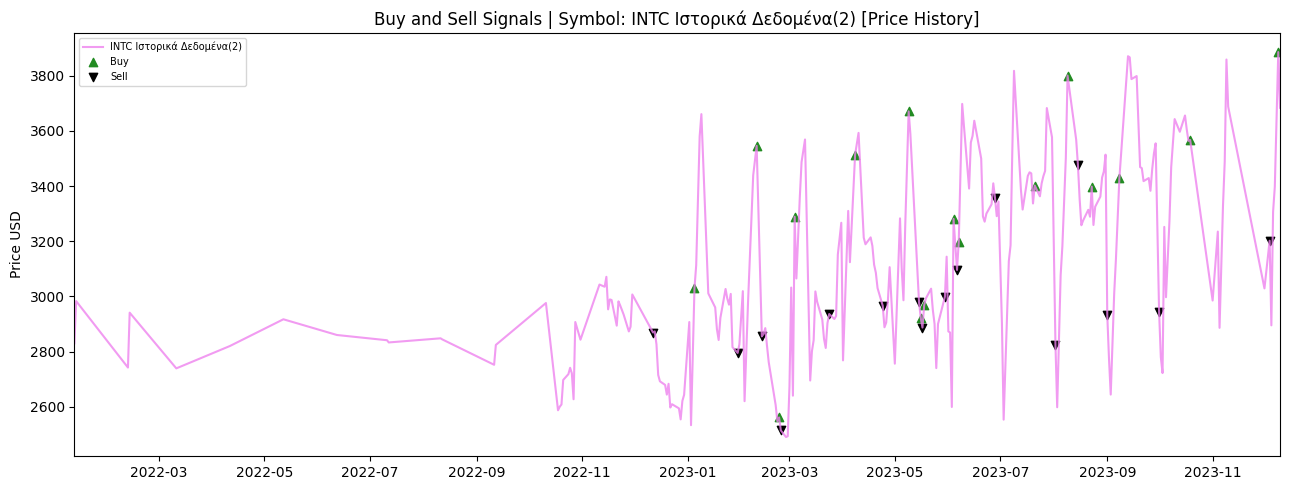

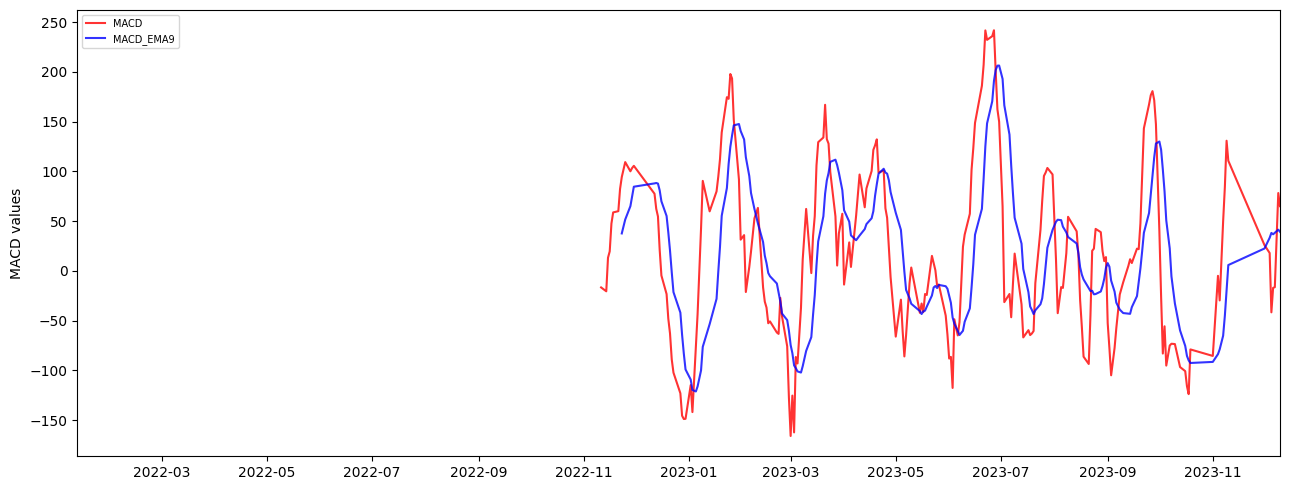

In [16]:
#Βήμα 7 | MACD Plot Analysis (Buy and Sell Signals)
macd_plot_total_signals(macd_results,macd_total_dates_report)